## Isotonic Regression

- In some use cases, you want to adjust some $X$ against some $y$ while maintaining a monotonic relationship between them
    - For example, in credit scoring, you want to adjust the model's probability of default (PD) outcome against the actual observed bad rate outcome
    - The point is to have your model's PD estimate match up against reality, so if you model says that there is 80% chance of a user defaulting, there truly is an 80% chance

- The implementation here is typically only used for single variable relationships.

## PAVA (Pool adjacent violaters algorithm) algorithm

- Isotonic regression optimises the same thing that OLS does; the sum of squared errors between the predicted to the observed outcome, subject to a monotonic constraint. That is:

$$\begin{aligned}
    \text{Given }& \\
    &x_1 \le x_2 \le ... x_n \\
    &y_1 \le y_2 \le ... y_n \\ \\

    \text{Minimize}& \\
    &\sum_{i}^{n} (y_i - \hat{y}_i)^2

\end{aligned}$$

- There isn't really a parametric way of doing this; so for this to happen we use a non-parametric approach called the "Pool Adjacent Violaters Algorithm", or PAVA

- The idea of PAVA is simple. Suppose we want to make a monotonically increasing estimate
    - Given arrays X and y, sort X in ascending order, and y in the same order
    - For each element of y, compare y[i] with the next element. Pass if y[i] <= y[i+1], since it does not violate the condition of monotonically increasing array
    - If y[i] > y[i+1], we've found a violation, which we resolve by taking a weighted average between y[i] and y[i+1]
        - The weights of the weighted average start at 1 for all elements (i.e. equally weighted). 
        - For each adjustment, the weight of both i and i+1 is the sum of the weights at i and i+1.
        - For each adjustment, the value of both i and i+1 is the weighted average of the 2 elements
    - You can imagine intuitively that adjusting a particular element becomes more difficult the more it is adjusted

## Implementation

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression

class MyIsotonicRegression:
    def __init__(self, increasing: bool = True):
        self.increasing=increasing
        self._is_fitted = False
    
    def fit(self, X, y):
        self.sorted_indices = np.argsort(X)
        xsort = X[self.sorted_indices]
        ysort = y[self.sorted_indices]

        yisotonic = self._pava(ysort)

        self.xsort = xsort
        self.yisotonic = yisotonic
        self.yisotonic_unsort = self.yisotonic[np.argsort(self.sorted_indices)]
        
        self._is_fitted = True

        return self

        # return self.yisotonic[np.argsort(sorted_indices)] ##unsort the array to return the original y

    def _is_adjacent_violater(self, curr_val, next_val) -> bool:
        if (
            ((self.increasing) and (curr_val > next_val)) or
            ((not self.increasing) and (curr_val < next_val))
        ):
            return True
        return False
        
    def _pava(self, y):
        i = 0
        weights = np.ones(y.shape)
        yisotonic = y.copy()
        while i < (len(yisotonic)-1): ##going from left to right...
            if self._is_adjacent_violater(yisotonic[i], yisotonic[i+1]): ## if the value at position i violates the adjacency condition...
                j = i 
                
                ### While the violation occurs, go leftwards from i (stored as j to avoid clashing index values), and average the values
                while (j >= 0) and (j+1 < len(yisotonic)) and (self._is_adjacent_violater(yisotonic[j], yisotonic[j+1])):
                    yisotonic[j] = yisotonic[j+1] = (
                        (yisotonic[j] * weights[j]) + (yisotonic[j+1] * weights[j+1])
                    ) / (weights[j] + weights[j+1])
                    weights[j] = weights[j+1] = weights[j] + weights[j+1]
                    j -= 1

                ## after going through all values leftwards, we've either reached a point where the is no adjacent violation, or reached the start of the array. If no violation, set to j+1 (since no violation at j). otherwise, set to 0 because we go through the whole array again to adjust the values
                i = max(0, j+1)
            else:
                i += 1
        
        return yisotonic
    
    def predict(self, X):
        ## To predict, we use np.searchsorted to return the array index where X is in
        if not self._is_fitted:
            raise ValueError('Call fit first')
        
        return self.yisotonic[np.searchsorted(self.xsort, X, side='right')-1]


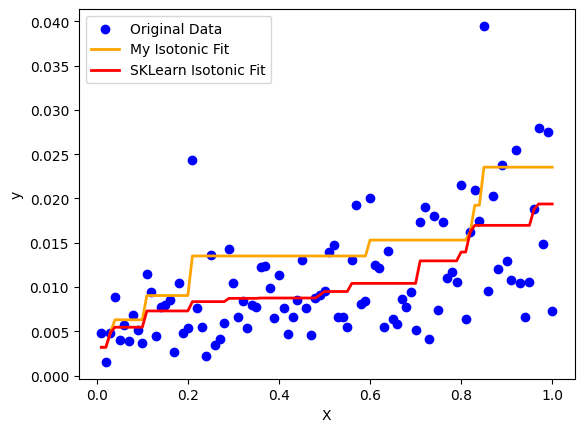

In [147]:
X = np.linspace(0.01, 1, 100)  # Sorted X values
y = np.exp(X + np.random.normal(0, 0.5, 100)) / sum(np.exp(X + np.random.normal(0, 0.5, 100)))

# Fit my isotonic regression
mir = MyIsotonicRegression(increasing=True)
mir.fit(X, y)
my_ypred = mir.predict(X)

# Fit SKLearn Isotonic Regression
ir = IsotonicRegression()
skl_ypred = ir.fit_transform(X, y)

# Plot results
plt.scatter(X, y, label="Original Data", color="blue")
plt.plot(X, my_ypred, label="My Isotonic Fit", color="orange", linewidth=2)
plt.plot(X, skl_ypred, label="SKLearn Isotonic Fit", color="red", linewidth=2)
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()